# Capstone: Employee Review Monitoring

---

#### 05: <b>Conclusion and Test set</b>

### Evaluation of models


Machine Learning model results:

![alt](../assets/ml_results.png)

RNN-LSTM model results:

<img src="../assets/dl_results.png" width="500" height="100">


Looking at the results above, Logistic Regression model with TFIDF-Vectorizer had performed the best overall. Hence, we will be choosing it as our production model for predicting sentiment of reviews from employees.

### Recommendations for further improvement

Areas for improvement:
- Try other estimators like KNN, XGBoost and RandomForest as well as other text normalization techniques such as Snowball or Lancaster Stemming.
- Further fine-tuning of RNN-LSTM model to improve training and validation scores.
- Try other deep learning models such as HuggingFace-BERT model using PyTorch.
- Using other pre-trained models from HuggingFace to predict sentiments of non-english reviews such as German and French.
- Deployment of models into an app that could upload quarterly reviews in csv format and gives an output to visualize the results for stakeholders.

## Test set

In [1]:
# Import libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Load the trained model
pickle_in = open('lr_tfidf.pkl', 'rb')
classifier = pickle.load(pickle_in)

In [3]:
# Load test set
testset = pd.read_csv('../data/test.csv')

In [4]:
testset.head()

,ID,Place,location,date,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6
0,5,startup_1,"Los Angeles, CA","Jul 19, 2018",Former Employee,Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5,5,5,5,5,49
1,6,startup_1,"Mountain View, CA","Dec 9, 2018",Former Employee,SDE2,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,NaN,4,4,4,5,4,1
2,7,startup_1,"New York, NY","Dec 11, 2018",Current Employee,Software Engineer,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,NaN,5,4,4,5,4,0
3,8,startup_1,NaN,"Dec 11, 2018",Former Employee,Anonymous Employee,great place to work and progress,"work culture, benefits, growth, people,",No cons that i can think of,NaN,5,5,5,5,5,0
4,9,startup_1,"New York, NY","Dec 10, 2018",Current Employee,Anonymous Employee,Google Surpasses Realistic Expectations,Great products. Vision you can feel good about...,Younger employees complaining about the compan...,NaN,5,5,5,5,5,0


In [5]:
# Cleaning and preprocessing function
def preprocessing(df):
    # Replace NaN values with ''
    df['summary'].fillna('', inplace = True)
    df['advice_to_mgmt'].fillna('', inplace = True)
    df['negatives'].fillna('', inplace = True)
    # Combine text columns related to reviews
    df['combined_text'] = df['summary'] + ' '\
                            + df['positives'] + ' '\
                            + df['negatives'] + ' '\
                            + df['advice_to_mgmt'] + ' '
    # Drop columns that were combined
    df.drop(columns = ['summary',
                       'positives',
                       'advice_to_mgmt'],axis = 1,inplace = True)
    # Drop Glassdoor review scores as we will not be relying on them
    # Drop ID
    df = df.select_dtypes(include =[object])
    # Instantiate tokernizer and lemmatizer
    w_tokenizer = WhitespaceTokenizer()
    lemmatizer = WordNetLemmatizer()

    # Function to lemmatize words in dataframe
    def lemma_text(text):
        return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

    df['combined_text_lemma'] = df['combined_text'].\
                                    apply(lemma_text)

    # Join all words with one spacing
    df['combined_text_lemma'] = df['combined_text_lemma'].\
                                    apply(lambda x: ' '.join(x))

    # Organize dataframe
    df.drop('combined_text',axis=1,inplace = True)
    
    return df

In [6]:
test = preprocessing(testset)

<ipython-input-5-c10c36bc405a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_text_lemma'] = df['combined_text'].\
<ipython-input-5-c10c36bc405a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_text_lemma'] = df['combined_text_lemma'].\
/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [7]:
prediction = classifier.predict(test['combined_text_lemma'])

In [8]:
import collections
collections.Counter(prediction)

Counter({1: 24619, 0: 4653})

In [9]:
test['sentiments'] = prediction

<ipython-input-9-6fd6aaf7dc26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sentiments'] = prediction


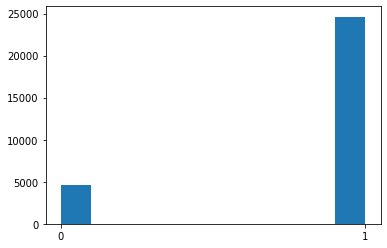

In [10]:
plt.hist(prediction)
plt.xticks(np.arange(2))
plt.show()

In [11]:
# Load the trained LDA model
pickle_in_lda = open('lda_model.pkl', 'rb')
best_lda_model = pickle.load(pickle_in_lda)

In [12]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [13]:
#Transform text to vector form using the vectorizer object 
tvec = TfidfVectorizer(strip_accents = 'unicode',
                        stop_words = 'english',
                        lowercase = True,
                        token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                        max_df = 0.9,                        # discard words that appear in > 90% of the reviews
                        min_df = 10)                         # discard words that appear in < 10 reviews    
#convert to document-term matrix
dtm_tfidf = tvec.fit_transform(testset['negatives'].tolist())


# Initiate the Model
best_lda_model = LatentDirichletAllocation(n_components=5, learning_decay=.7, batch_size = 64)


# fit GridSearch
best_lda_model.fit(dtm_tfidf)

pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tvec)

/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.080590  0.046130       1        1  30.833007
3      0.047117 -0.034585       2        1  30.097380
4      0.227847 -0.007853       3        1  14.205726
2     -0.078274  0.177330       4        1  13.149334
1     -0.116100 -0.181023       5        1  11.714553, topic_info=            Term         Freq        Total Category  logprob  loglift
676         cons   519.000000   519.000000  Default  30.0000  30.0000
1980        life   641.000000   641.000000  Default  29.0000  29.0000
278      balance   593.000000   593.000000  Default  28.0000  28.0000
3900        work  1330.000000  1330.000000  Default  27.0000  27.0000
3537       think   386.000000   386.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1251  experience    52.821759   158.378819   Topic5  -5.2485   1.0463
271          bad    61.458970   316.510031   Topic5  -5.0971   0.5054
3559        time    59.356186   551.473623   Topic5  -5.1319  -0.0847
3536      things    50.334451   211.272443   Topic5  -5.2968   0.7099
1864         job    52.401277   367.725613   Topic5  -5.2565   0.1959

[399 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
25        1  0.935321  accountability
44        3  0.951921          active
51        1  0.976681           adapt
76        1  0.255087     advancement
76        2  0.198401     advancement
...     ...       ...             ...
3931      1  0.256622            year
3931      2  0.622114            year
3931      3  0.038882            year
3931      4  0.077764            year
3931      5  0.007776            year

[853 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])